# **CSE422 Lab: Neural Networks**


## **Neural Networks**
In machine learning, a neural network (also artificial neural network abbreviated ANN) is a model inspired by the structure and function of biological neural networks in animal brains.



### **Forward Propagation**

The forward propagation of a single layer can be mathematically expressed as follows:

Let $f$ be the activation function. Then, for the $l^{th}$ layer, the input is $A^{[l-1]}$ and the output $A^{[l]}$ is computed as:

$$Z^{[l]} = W^{[l]}A^{[l-1]} + B^{[l]}$$
$$A^{[l]} = f(Z^{[l]})$$

where $W^{[l]}$ is the weight matrix connecting $(l-1)^{th}$ layer to $l^{th}$ layer, $B^{[l]}$ is the bias matrix of $l^{th}$ layer, and $Z^{[l]}$ is the pre-activation output $l^{th}$ layer.

### **Backpropagation**

The backpropagation of a single layer can be mathematically expressed as follows:

Let $Y$ be the output, $f$ be the activation function, and $E$ be the cost function. The upstream gradient for the output layer $D_u^{[L]}$, where $L$ is the number of layers in the network, is computed as:

$$D_u^{[L]} = \nabla_Y E$$

Let $D^{[l]} = \nabla_{Z^{[l]}} E$, where, $Z^{[l]}$ be the pre-activation output of $l^{th}$ layer. For $l^{th}$ layer, $D^{[l]}$ is computed as:

$$D^{[l]} = D_u^{[l]} \odot f'(Z^{[l]})$$

Then, the partial derivatives of the cost function with respect to weight matrix $W^{[l]}$ and bias matrix $B^{[l]}$ are computed as:

$$\nabla_{W^{[l]}} E = D^{[l]} {A^{[l-1]}}^\mathsf{T}$$
$$\nabla_{B^{[l]}} E = D^{[l]}$$

where $A^{[l-1]}$ is the input from $(l-1)^{th}$ layer. Finally, the weight matrix $W^{[l]}$ and bias matrix $B^{[l]}$ are updated using the following equations:

$$W^{[l]} \rightarrow W^{[l]} - \eta \nabla_{W^{[l]}} E$$
$$B^{[l]} \rightarrow B^{[l]} - \eta \nabla_{B^{[l]}} E$$

where $\eta$ is the learning rate of the network.

In the end, for $(l-1)^{th}$ layer, the upstream gradient $D_u^{[l-1]}$ is computed as:

$$D_u^{[l-1]} = {D^{[l]} W_1^{[l]}}^\mathsf{T}$$

## **Implementation**

### **Necassary Libraries**

In [ ]:
import numpy as np

from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import pandas as pd
from matplotlib import pyplot as plt

### **Activation Function**

In [ ]:
class ReLU:
    # Apply activation function
    def forwardPropagation(self, inp: np.array) -> np.array:
        self.inputAct = np.maximum(0, inp)
        return self.inputAct

    # Calculate derivative of the activation function
    def backPropagation(self, delta: np.array) -> np.array:
        return delta * np.where(self.inputAct > 0, 1, 0)

### **Loss Function**

In [ ]:
class MeanSquareError:
  def loss(self, Y: np.array, y:np.array) -> np.array:
      self.Y = Y
      self.y = y
      return np.absolute((Y - y) ** 2).sum() / y.shape[0]

  # Calculate derivative of the loss function
  def deriv(self) -> np.array:
      return (self.Y - self.y) / self.y.shape[0]

### **Optimizer**

In [ ]:
class GradientDescent:
    def __init__(self, learningRate) -> None:
        self.learningRate = learningRate

    # Calculate gradients
    def gradients(self, gradients) -> np.array:
        return self.learningRate * gradients

### **Necassary Functions**

In [ ]:
# To get activation function
def getActivationFunction(activation: str) -> object:
    if activation == "RELU":
        return ReLU
    else:
        raise Exception("Cannot find the activation function.")

# To get loss function
def getLossFunction(loss: str) -> object:
    if loss == "MSE":
        return MeanSquareError
    else:
        raise Exception("Cannot find the loss function.")

# To get optimizer
def getOptimizer(optimizer: str) -> object:
    if optimizer == "GD":
        return GradientDescent
    else:
        raise Exception("Cannot find the optimizer.")

### **Single Layer of Neurons**

In [ ]:
class NeuronLayer:
    def __init__(self, inputNeurons, outputNeurons, activation, biasFlag = True, randomState = 42) -> None:
        np.random.seed(randomState)
        # set variables
        self.inputNeurons = inputNeurons
        self.outputNeurons = outputNeurons
        self.biasFlag = biasFlag

        # get activation
        self.activation = getActivationFunction(activation)()

        # initiate parameters
        self.weights = self.__initParameters((self.inputNeurons, self.outputNeurons))
        self.bias = self.__initParameters((1, self.outputNeurons))

    # Parameter initializer
    def __initParameters(self, dimension: tuple) -> np.array:
        return np.random.uniform(-np.sqrt(2/(dimension[0] + dimension[1])), np.sqrt(2/(dimension[0] + dimension[1])),size = (dimension[0], dimension[1]))

    def build(self, optimizer, learningRate) -> None:
        self.learningRate = learningRate
        self.optimizer = getOptimizer(optimizer)(learningRate)

    # Apply forward propagation
    def forwardPropagation(self, X: np.array) -> np.array:
        self.X = X

        # Calculate weighted sum
        self.output = np.dot(self.X, self.weights) + (self.biasFlag * self.bias)
        # Apply activation function
        self.output = self.activation.forwardPropagation(self.output)

        return self.output

    # Apply backpropagation
    def backPropagation(self, upstreamGradient: np.array) -> np.array:
        # Calculate activation gradients
        delta = self.activation.backPropagation(upstreamGradient)

        # Calculate parameter gradients
        weightGrad = np.dot(self.X.T, delta) / self.X.shape[0]
        biasGrad = np.dot(np.ones((1, self.X.shape[0])), delta) /  self.X.shape[0]

        # Update parameters
        self.weights -= self.optimizer.gradients(weightGrad)
        self.bias -= self.optimizer.gradients(biasGrad)

        # Calculate downstream gradients
        downstreamGradient = np.dot(delta, self.weights.T) / self.X.shape[0]

        return downstreamGradient

### **Model**

In [ ]:
class Model:
    # Create mini-batches
    def __createBatch(self, X: np.array, Y: np.array, batchSize: int) -> tuple:
        miniX, miniY = np.array([X[:batchSize]]), np.array([Y[:batchSize]])

        for idx in range(1, X.shape[0] // batchSize):
            miniX = np.append(miniX, np.array([X[idx * batchSize : (idx + 1) * batchSize]]), axis = 0)
            miniY = np.append(miniY, np.array([Y[idx * batchSize : (idx + 1) * batchSize]]), axis = 0)

        return miniX, miniY

    # Apply forward propagation over the model
    def __forwardPropagation(self, X: np.array) -> np.array:
        output = X
        for layer in self.layers:
            output = layer.forwardPropagation(output)
        return output

    # Apply backpropagation over the model
    def __backPropagation(self, Y: np.array) -> None:
        gradient = Y
        for layer in self.layers[::-1]:
            gradient = layer.backPropagation(gradient)

    def layers(self, layers: list) -> None:
        self.layers = layers

    # Compile the model
    def compile(self, loss, optimizer, learningRate) -> None:
        self.loss = getLossFunction(loss)()
        for layer in self.layers[::-1]:
            layer.build(optimizer, learningRate)

    # Predict the output
    def predict(self, X: np.array) -> np.array:
        return self.__forwardPropagation(X)

    # Evaluate the model
    def evaluate(self, X: np.array, Y: np.array) -> np.array:
        output = self.predict(X)
        return self.loss.loss(output, Y)

    # Train the model
    def fit(self, X: np.array, Y: np.array, epochs: int, batchSize = None) -> np.array:
        # Create mini-batch
        batchSize = (batchSize if batchSize else X.shape[0])
        self.X, self.Y = self.__createBatch(X, Y, batchSize)

        self.error = np.array([])
        # Run epoch
        for epoch in range(epochs):
            epochError = np.array([])

            # Iterate over mini-batches
            for idx in range(self.X.shape[0]):
                epochError = np.append(epochError, self.loss.loss(self.__forwardPropagation(self.X[idx]), self.Y[idx]))
                self.__backPropagation(self.loss.deriv())

            # Print epoch information
            epochError /= epochError.shape[0]
            self.error = np.append(self.error, epochError.sum() / epochError.shape[0])
            print("Epoch:", epoch + 1, "Error:", round(epochError[0], 2))

        return self.error

### **Load Dataset**

In [ ]:
# Import dataset
(X_train, Y_train), (X_test, Y_test) = boston_housing.load_data(path='boston_housing.npz', test_split=0.2, seed=42)
# Reshape target variable
Y_train, Y_test = Y_train.reshape(Y_train.shape[0], 1), Y_test.reshape(Y_test.shape[0], 1)

# Create Dataframe
dataset = pd.DataFrame(np.concatenate((X_train, X_test), axis=0))
dataset['Target'] = np.concatenate((Y_train, Y_test), axis = 0)
dataset

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,Target
0,0.09178,0.0,4.05,0.0,0.510,6.416,84.1,2.6463,5.0,296.0,16.6,395.50,9.04,23.6
1,0.05644,40.0,6.41,1.0,0.447,6.758,32.9,4.0776,4.0,254.0,17.6,396.90,3.53,32.4
2,0.10574,0.0,27.74,0.0,0.609,5.983,98.8,1.8681,4.0,711.0,20.1,390.11,18.07,13.6
3,0.09164,0.0,10.81,0.0,0.413,6.065,7.8,5.2873,4.0,305.0,19.2,390.91,5.52,22.8
4,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,20.2,385.09,17.27,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.17120,0.0,8.56,0.0,0.520,5.836,91.9,2.2110,5.0,384.0,20.9,395.67,18.66,19.5
502,0.29916,20.0,6.96,0.0,0.464,5.856,42.1,4.4290,3.0,223.0,18.6,388.65,13.00,21.1
503,0.01501,80.0,2.01,0.0,0.435,6.635,29.7,8.3440,4.0,280.0,17.0,390.94,5.99,24.5
504,11.16040,0.0,18.10,0.0,0.740,6.629,94.6,2.1247,24.0,666.0,20.2,109.85,23.27,13.4


### **Model Training**

In [ ]:
# Create model
model = Model()
model.layers = [NeuronLayer(13, 64, "RELU"), NeuronLayer(64, 1, "RELU")]
# Compile model
model.compile(loss="MSE",
              optimizer="GD",
              learningRate=0.01)

# Train model
training_Error = model.fit(X_train, Y_train, epochs=300, batchSize=None)

Epoch: 1 Error: 226.65
Epoch: 2 Error: 192.81
Epoch: 3 Error: 167.51
Epoch: 4 Error: 148.38
Epoch: 5 Error: 133.75
Epoch: 6 Error: 122.44
Epoch: 7 Error: 113.6
Epoch: 8 Error: 106.62
Epoch: 9 Error: 101.07
Epoch: 10 Error: 96.61
Epoch: 11 Error: 92.99
Epoch: 12 Error: 90.05
Epoch: 13 Error: 87.63
Epoch: 14 Error: 85.63
Epoch: 15 Error: 83.97
Epoch: 16 Error: 82.58
Epoch: 17 Error: 81.41
Epoch: 18 Error: 80.42
Epoch: 19 Error: 79.57
Epoch: 20 Error: 78.84
Epoch: 21 Error: 78.22
Epoch: 22 Error: 77.67
Epoch: 23 Error: 77.19
Epoch: 24 Error: 76.77
Epoch: 25 Error: 76.39
Epoch: 26 Error: 76.06
Epoch: 27 Error: 75.75
Epoch: 28 Error: 75.48
Epoch: 29 Error: 75.22
Epoch: 30 Error: 74.98
Epoch: 31 Error: 74.77
Epoch: 32 Error: 74.56
Epoch: 33 Error: 74.37
Epoch: 34 Error: 74.18
Epoch: 35 Error: 74.01
Epoch: 36 Error: 73.84
Epoch: 37 Error: 73.68
Epoch: 38 Error: 73.53
Epoch: 39 Error: 73.38
Epoch: 40 Error: 73.23
Epoch: 41 Error: 73.09
Epoch: 42 Error: 72.96
Epoch: 43 Error: 72.83
Epoch: 44 Er

### **Model Evaluation**

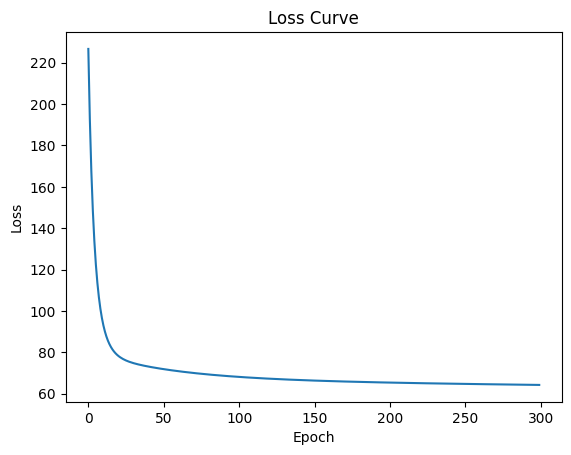

Testing Error: 64.3


In [ ]:
# Plot loss curve
plt.plot(training_Error)
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#Print test error
print(f"Testing Error: {round(model.evaluate(X_test, Y_test), 2)}")

## **Tensorflow for Neural Networks**

TensorFlow is an open-source machine learning framework developed by Google. It provides tools and libraries to build and train neural networks and other machine learning models, especially for deep learning tasks.

### **Load Dataset**

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


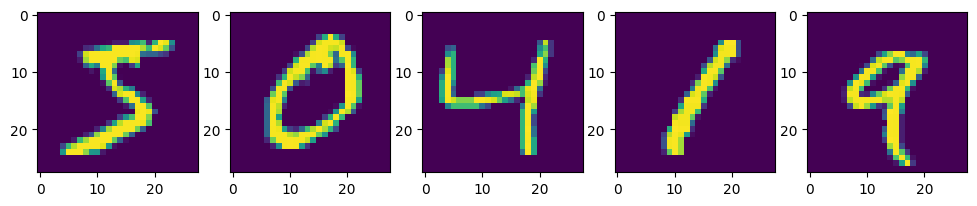

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 12))

# Insert images
for i in range(5):
    axes[i].imshow(X_train[i])

plt.show()

### **Preprocess Data**

In [ ]:
X_train, X_test, Y_train, Y_test = X_train.astype("float32") / 255, X_test.astype("float32") / 255, Y_train.astype("float32"), Y_test.astype("float32")

### **Model Training**

In [ ]:
# Create model
model = Sequential([
  Flatten(input_shape=(28, 28)),
  Dense(128, activation='relu'),
  Dense(10, activation="softmax")
])

# Compile model
model.compile(optimizer=Adam(0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, Y_train, epochs = 20, batch_size=128)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8255 - loss: 0.6357
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9492 - loss: 0.1774
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9640 - loss: 0.1233
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9748 - loss: 0.0881
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9794 - loss: 0.0732
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9820 - loss: 0.0614
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9864 - loss: 0.0504
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9879 - loss: 0.0414
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9899 - loss: 0.0368
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9914 - loss: 0.0302
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9929 - loss: 0.0263
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy

### **Model Evaluation**

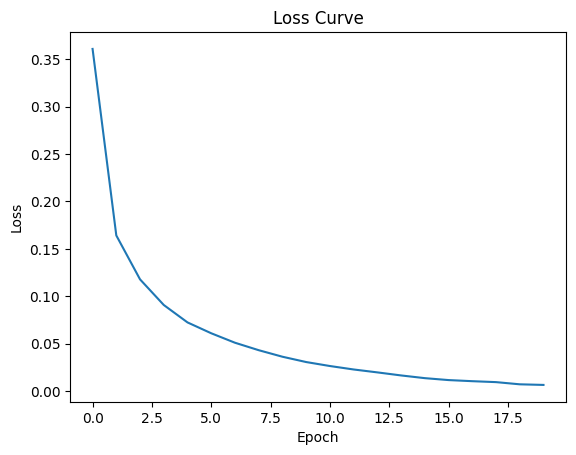

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9719 - loss: 0.1003
Testing Accuracy: 97.64%


In [ ]:
# Plot loss curve
plt.plot(history.history['loss'])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#Print test error
print(f"Testing Accuracy: {round(model.evaluate(X_test, Y_test)[1] * 100, 2)}%")